In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import matplotlib.animation as manimation

In [2]:
def init_movie(movie_name, creator, comment):
    FFMpegWriter = manimation.writers['ffmpeg']
    metadata = dict(title=movie_name, artist=creator,
                    comment=comment)
    return FFMpegWriter(fps=15, metadata=metadata)

def generate_init_conditions(number_of_birds, box_size, NBP=1):
    
    XY = np.random.uniform(low=0, high=box_size, size=(number_of_birds,2))         #generate starting positions of birds
    q = np.random.uniform(low=-np.pi, high=np.pi, size=(number_of_birds,))   #generate starting orientations of birds
    


    BP = np.random.uniform(low=box_size/2, high=box_size/2, size=(NBP,2))      #generates starting position of the bird of prey in the middle of a box
    qBP = np.random.uniform(low=-np.pi, high=np.pi, size=(NBP,)) #generates starting orientation of bird of prey

    return XY, BP, q, qBP

def update(XY,BP,q,qBP,number_of_birds, disorder_parameter,box_size):
        T = cKDTree(XY, boxsize=[box_size,box_size]) #create cKDTree 
        
        distance_matrix = T.sparse_distance_matrix(T,interaction_radious,output_type='coo_matrix') #for each bird find all birds in a range smaller than r (result is  a sparse matrix)
        
         
        
        distance_matrix.setdiag(q)                 #set 'self-direction'; so if no birds nearby, stay on course
        
        distance_matrix.data = np.exp(1j*q[distance_matrix.nonzero()[1]])     #for each bird change distances to the neighbours to exponents of directions
        
        averge_angle = np.ravel(np.angle(np.sum(distance_matrix,axis=1)))     #for each bird calculate the angle of the vector sum of velocities of birds  
        
        q = averge_angle + disorder_parameter*np.random.uniform(low=-np.pi, high=np.pi, size=(number_of_birds,))  #new direction is avg plus some random factor

        bird = T.query_ball_point(BP, exclusion_zone)           #all birds in range rb from the bird of prey

        prey = T.query(BP, 1)                      #the nearest neighbour of the bird of prey; prey[0]= distance to prey; prey[1]= index of bird
        
    
        dx = np.remainder(XY[bird[0],0]-BP[:,0] + box_size/2., box_size)-box_size/2        # vectors connecting bird of prey and birds in range rb
        dy = np.remainder(XY[bird[0],1]-BP[:,1] + box_size/2., box_size)-box_size/2
        cosines = dx/np.sqrt(dx**2+dy**2)                           # cosines of directions from bird of prey to birds in range rb
        angles = np.where(dy>0,(np.arccos(cosines)),-(np.arccos(cosines))) # arccos is not unique function on [-pi,pi]; 
        
        
        q[bird[0]] = angles+disorder_parameter*np.random.uniform(low=-np.pi, high=np.pi,size=(len(bird[0]),)) #if there are birds in range rb from bird of prey update their velocities    
        qBP=q[prey[1]]+disorder_parameter*np.random.uniform(low=-np.pi, high=np.pi)      #bird of prey moves towards nearest bird

        
        BP[:,0] = (BP[:,0]+v0*dt*np.cos(qBP))%box_size
        BP[:,1] = (BP[:,1]+v0*dt*np.sin(qBP))%box_size   #update the position of the bird of prey
        
        
        XY[:,0] = (XY[:,0]+v0*dt*np.cos(q))%box_size
        XY[:,1] = (XY[:,1]+v0*dt*np.sin(q))%box_size      #update the positions of birds
        
        return XY, BP, q, qBP
    
def generate_frame():
    fig, ax = plt.subplots()
    plt.tight_layout()
    plt.xlabel('X')                                         #x axis label
    plt.ylabel('Y')                                         #y axis label
    plt.xlim([0,box_size])                                         #x axis range
    plt.ylim([0,box_size])                                         #y axis range
    
    return fig, ax

def new_frame(fig,ax,XY,BP,q,qBP,exclusion_zone):
    
        ax.clear()                                                          #clear vector fields
        plt.xlim([0,box_size])
        plt.ylim([0,box_size])
        
        plt.title(f"t = {t*dt:.2f}" )
        
        ax.quiver(XY[:,0],XY[:,1],np.cos(q)*v0,np.sin(q)*v0,q)            #show vector field of birds
        ax.scatter(BP[:,0],BP[:,1],marker="o",s=1,c="r")                  #show bird of prey (as a point)
        ax.quiver(BP[:,0],BP[:,1],np.cos(qBP)*v0,np.sin(qBP)*v0,color="r")
            
        if show_additional_features:
            radius = plt.Circle((BP[:,0],BP[:,1]), exclusion_zone, color='r', fill=False)
            plt.gca().add_patch(radius)  #show the exclusion radious
           



        writer.grab_frame()
        return fig, ax

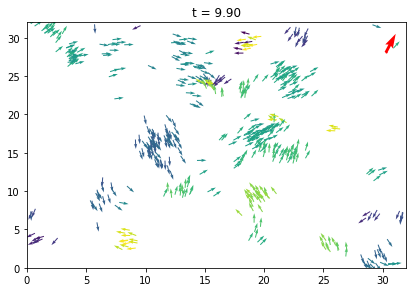

In [3]:

#----------movie parameters----------
number_of_frames        = 100           #number of frames
dpi                     = 250           #dpi of resulting movie 
file_name               = 'birds'       #name of .mp4 file  

movie_name              = 'Bird of prey'   #metadata
creator                 = 'Michal Marciniak'
comment                 = 'short animation' 
#----------parameters ----------
box_size                 = 32   #sandbox size
NBP                      = 1    #number of birds of prey; do not change
number_of_birds          = 500  #number of birds
v0                       = 2    #velocity of birds and bird of prey  
disorder_parameter       = 0.1  #disorder parameter; how much bird of prey misses the orientation of the closest bird
interaction_radious      = 1    #interaction distance for birds; 
dt                       = 0.1  #time step
exclusion_zone           = 4    #range of bird of prey; from what distance other birds see bird of prey
show_additional_features = False
#------------------------------------

writer = init_movie(movie_name, creator, comment)   #define metadata for .mp4 file

#-----  init -----
#create an empty plot with axis X and Y
fig, ax = generate_frame()

XY, BP, q, qBP = generate_init_conditions(number_of_birds, box_size)


with writer.saving(fig, str(file_name)+".mp4", dpi):          # save fig to writer_test.mp4 dpi=250  
    for t in range(number_of_frames):                      
        if t%10 == 0: print(f"\r {t/number_of_frames*100:.2f}%",end="\r")  # print progress
        
        XY, BP, q, qBP = update(XY, BP, q, qBP, number_of_birds, disorder_parameter, box_size)
        
        new_frame(fig, ax, XY, BP, q, qBP)
        